In [19]:
import pandas as pd
import numpy as np
import json
import os

In [2]:
os.getcwd()

'/home/yiyi/Documents/masterthesis/CPD/topic_modeling'

In [3]:
filepath='/home/yiyi/Documents/masterthesis/CPD/data/renovated_hotels_content20200420.json'

In [19]:
with open(filepath) as file:
    data = json.load(file)

In [20]:
not_matched = [44, 49, 84, 138, 177, 181, 245, 274, 302, 324,392, 403, 430]

In [21]:
aspects = [
    "room", "suites", "bathroom", "furniture","guestroom",
    "meeting" , "event",
    "lobby", "atrium",
    "view", 
    "entertainment",
    "pool",
    "café",
    "ballroom",
    "restaurant", "bar",
    "interior",
    "exterior",
    "reception", 
    "lounge",
    
]

In [20]:
from nltk.tokenize import sent_tokenize
import regex
from spacy.lang.en.stop_words import STOP_WORDS

In [21]:
import spacy
nlp=spacy.load("en_core_web_sm")

In [9]:
example="La Colección, a selection of 12 resorts that encompasses the brands Live Aqua Resorts, Grand Fiesta Americana Hotels & Resorts, Fiesta Americana Hotels & Resorts and The Explorean, is pleased to announce the completion of a multimillion dollar renovation at Fiesta Americana Condesa Cancun All Inclusive. The resort and area icon now showcases fully enhanced guestrooms in its three towers and an upgraded Grand Ballroom Condesa that complement its favored all-inclusive Mexican vacation experience that showcases authentic traditions and culture, family-friendly amenities and first-class meetings and events offering."

In [10]:
sents = sent_tokenize(example)

In [14]:
for sent in sents:
    doc = nlp(sent)
    
#     for noun_phrase in list(doc.noun_chunks):
#         noun_phrase.merge(noun_phrase.root.tag_, noun_phrase.root.lemma_, noun_phrase.root.ent_type_)
    for token in doc:
        print(token.text, token.pos_)

La PROPN
Colección PROPN
, PUNCT
a DET
selection NOUN
of ADP
12 NUM
resorts NOUN
that DET
encompasses VERB
the DET
brands NOUN
Live VERB
Aqua PROPN
Resorts PROPN
, PUNCT
Grand PROPN
Fiesta PROPN
Americana PROPN
Hotels PROPN
& CCONJ
Resorts PROPN
, PUNCT
Fiesta PROPN
Americana PROPN
Hotels PROPN
& CCONJ
Resorts PROPN
and CCONJ
The DET
Explorean PROPN
, PUNCT
is AUX
pleased ADJ
to PART
announce VERB
the DET
completion NOUN
of ADP
a DET
multimillion ADJ
dollar NOUN
renovation NOUN
at ADP
Fiesta PROPN
Americana PROPN
Condesa PROPN
Cancun PROPN
All DET
Inclusive ADJ
. PUNCT
The DET
resort NOUN
and CCONJ
area NOUN
icon PROPN
now ADV
showcases VERB
fully ADV
enhanced VERB
guestrooms NOUN
in ADP
its DET
three NUM
towers NOUN
and CCONJ
an DET
upgraded VERB
Grand PROPN
Ballroom PROPN
Condesa PROPN
that DET
complement VERB
its DET
favored VERB
all DET
- PUNCT
inclusive ADJ
Mexican ADJ
vacation NOUN
experience NOUN
that DET
showcases VERB
authentic ADJ
traditions NOUN
and CCONJ
culture NOUN
, PUNC

In [23]:
from itertools import chain

In [17]:
from utils.timer import Timer
import string

In [45]:
schedules = []
sentences =[]

dictionary_aspects= {}

timer= Timer()
timer.start()
for content in data:
    idx = content['id']
    if idx not in not_matched:
        sentence =[]
        hotelname = content['hotelName']
        subtitles = content['subtitle']
        cont = content['content']
        d = subtitles[-1].split('–')
        
        if d[0] and d[0].startswith('Scheduled'):
            reopen_time = d[0].replace('Scheduled for ', '')
            if reopen_time:
                schedules.append(reopen_time)
                
        for paragraph in cont:
            if paragraph !="\n":
                
                sents = sent_tokenize(paragraph)
                for sent in sents:
                    relate = []
                    doc = nlp(sent)
                    ent_tokens = [ent.text.split() for ent in doc.ents]
                    ent_tokens = list(chain.from_iterable(ent_tokens))
                    
                    # get only lemmas and non entities.
                    for token in doc:
                        if token.text not in ent_tokens and token.text not in STOP_WORDS:
                            if token.pos_ in ['PROPN', 'NOUN', 'VERB','ADJ'] and not token.is_punct:
                                t = token.lemma_.translate(str.maketrans('', '', string.punctuation)).strip()
                                if len(t)>1:
                                    relate.append(t.lower())
                    if len(relate)>2:
                        sentences.append(relate)
                        sentence.append(relate)
            dictionary_aspects[idx]= sentence
timer.stop()

Elapsed time: 47.2137 seconds


In [ ]:
len(sentences)

In [ ]:
sentences[:10]

In [26]:
# import pickle
# with open('sentences.pkl','wb')as file:
#     pickle.dump(sentences, file)

In [4]:
import pickle
with open('sentences.pkl', 'rb') as file:
    sentences = pickle.load(file)

In [6]:
# import json 
# with open('/home/yiyi/Documents/masterthesis/CPD/data/hospitalityNet_hotel_aspects.json', 'w')as file:
#     json.dump(dictionary_aspects, file)

In [17]:
# https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/

In [28]:
import numpy as np
lens =[len(sent) for sent in sentences]
np.median(lens) , np.mean(lens), np.max(lens)


(11.0, 12.242080179422484, 58)

In [29]:
from gensim.models import Word2Vec
model = Word2Vec(sentences,size=200, window=6, min_count=2, workers=8, iter=200, negative=5)

In [37]:
model.vector_size, len(model.wv.vocab)

(200, 4263)

In [38]:
model.most_similar('view', topn=20)

/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('vista', 0.4270409047603607),
 ('perch', 0.42042872309684753),
 ('overlook', 0.34683653712272644),
 ('balcony', 0.3127508759498596),
 ('terrace', 0.29943856596946716),
 ('panoramic', 0.2940656542778015),
 ('breeze', 0.2929036319255829),
 ('backdrop', 0.28438282012939453),
 ('rarity', 0.28423428535461426),
 ('uninterrupted', 0.28322410583496094),
 ('overwater', 0.27970176935195923),
 ('skyline', 0.27953606843948364),
 ('renaissance', 0.2787865996360779),
 ('seclusion', 0.27351126074790955),
 ('vistas', 0.2585688829421997),
 ('patio', 0.25499746203422546),
 ('private', 0.2493060678243637),
 ('bandwidth', 0.24848279356956482),
 ('window', 0.24314753711223602),
 ('scenery', 0.24297493696212769)]

In [44]:
model.most_similar('renovate', topn=50)

/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('renovation', 0.29658204317092896),
 ('new', 0.2963961660861969),
 ('additional', 0.2834628224372864),
 ('suite', 0.2606421709060669),
 ('lobby', 0.253612220287323),
 ('room', 0.24985244870185852),
 ('remodel', 0.24931523203849792),
 ('floor', 0.24202120304107666),
 ('exterior', 0.2409266233444214),
 ('refurbish', 0.23676377534866333),
 ('revamp', 0.22743786871433258),
 ('grand', 0.22628694772720337),
 ('meeting', 0.22482340037822723),
 ('lounge', 0.22393319010734558),
 ('upgrade', 0.22121959924697876),
 ('presidential', 0.2202739417552948),
 ('revitalize', 0.21617360413074493),
 ('refresh', 0.2158096879720688),
 ('space', 0.21567687392234802),
 ('multifunctional', 0.21249355375766754),
 ('appoint', 0.2089328020811081),
 ('late', 0.2087416797876358),
 ('reimagine', 0.2087179720401764),
 ('update', 0.2085898518562317),
 ('total', 0.20824703574180603),
 ('public', 0.20795631408691406),
 ('restaurant', 0.20519554615020752),
 ('luxurious', 0.20324495434761047),
 ('revitalization', 0.2013

In [40]:
model.similarity('pool', 'swim')

/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.29956225

In [52]:
model.most_similar('renovation', topn=20)

/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('transformation', 0.5038843750953674),
 ('hotel', 0.43146654963493347),
 ('phase', 0.4283737540245056),
 ('enhancement', 0.41524258255958557),
 ('suite', 0.4041217863559723),
 ('restoration', 0.39345410466194153),
 ('refurbishment', 0.3794313669204712),
 ('remodel', 0.3730311989784241),
 ('ii', 0.36552244424819946),
 ('resort', 0.35930755734443665),
 ('project', 0.35906684398651123),
 ('new', 0.3569549322128296),
 ('comprehensive', 0.3548692464828491),
 ('unveil', 0.3495545983314514),
 ('dollar', 0.34872180223464966),
 ('property', 0.3353404104709625),
 ('revitalization', 0.3317023515701294),
 ('period', 0.3289315700531006),
 ('redesign', 0.32763057947158813),
 ('undergo', 0.32205507159233093)]

In [26]:
model.similarity('lighting','room')

/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.14854294

In [49]:
model.save('/home/yiyi/Documents/masterthesis/CPD/data/word2vec_model_200_iter_neg_5_win_6')

In [55]:
def sent_vectorizer(sent, model):
    sent_vec = []
    numw = 0
    for w in sent:
        try:
            if numw==0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw += 1
        except:
            pass
    return np.asarray(sent_vec) / numw

In [59]:
features = list(model.wv.vocab)

In [89]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA, NMF

from gensim.models import LdaModel, CoherenceModel
from gensim.corpora.dictionary import Dictionary
from corextopic import corextopic as ct

/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [71]:
sentences_string =[]
for sent in sentences:
    sentences_string.append(' '.join(sent))

In [72]:
sentences_string[:2]

['embassy suites downtown', 'complete final phase dollar property renovation']

In [73]:
cv_vectorizer = CountVectorizer() # from helper.py
cv_docs = cv_vectorizer.fit_transform(sentences_string)
cv_features = cv_vectorizer.get_feature_names()
tf_vectorizer = TfidfVectorizer() # from helper.py
tf_docs = tf_vectorizer.fit_transform(sentences_string)
tf_features = tf_vectorizer.get_feature_names()
print('Num. Features (Count Vec): ', len(cv_features))
print('Num. Features (TFIDF Vec): ', len(tf_features))
print('')
print('Dim. Docs (Count Vec): ', cv_docs.shape)
print('Dim. Docs (TFIDF Vec): ', tf_docs.shape)

Num. Features (Count Vec):  6984
Num. Features (TFIDF Vec):  6984

Dim. Docs (Count Vec):  (7128, 6984)
Dim. Docs (TFIDF Vec):  (7128, 6984)


In [93]:
model.most_similar('ocean', topn=10)

/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('lagoon', 0.3540167808532715),
 ('sea', 0.29749220609664917),
 ('sunshine', 0.2973877191543579),
 ('tv', 0.29049259424209595),
 ('expansive', 0.2895280718803406),
 ('turquoise', 0.28922024369239807),
 ('overwater', 0.2741917371749878),
 ('incredible', 0.27005329728126526),
 ('perch', 0.2608832120895386),
 ('immersion', 0.2570207118988037)]

In [97]:
aspects = [
    ["room", "suites", "bathroom", "furniture","guestroom"],
    ["meeting" , "event" ,"ballroom"],
    ["lobby", "atrium" , "reception", "lounge"],
    ["view","vista", "panoramic", "window", "scenery"], 
    ["pool", 'gym'],
    ["restaurant", "bar", "café"],
    ["renovation", "refresh", "transformation", "redesign", "remodel"]
]

In [106]:
aspects_dict= {
    0: 'room',
    1: 'meeting',
    2: 'lobby',
    3: 'view',
    4: 'pool',
    5: 'restaurant',
    6: 'renovation'
}

In [102]:
topic_model = ct.Corex(n_hidden=len(aspects), seed=42)

In [103]:
topic_model.fit(cv_docs, words=cv_features, anchors=aspects, anchor_strength=6 )

In [111]:
topic_words = dict()
for topic_n,topic in enumerate(topic_model.get_topics()):
    words,mis = zip(*topic)
    print(mis)
    topic_str = str(topic_n+1)+': '+', '.join(words)
    print(topic_str)
    topic_words['t_'+ aspects_dict[topic_n]] = words

(0.4590060663406843, 0.07394128187185246, 0.04612714015429687, 0.04226790842278602, 0.011652809566145818, 0.057881983098476246, 0.024838565540273937, 0.014516380457897347, 0.012921635009991751, 0.009198084844607511)
1: room, guestroom, bathroom, furniture, suites, suite, guest, include, shower, feature
(0.23006285450603323, 0.1578328404565233, 0.03479937539459509, 0.0872119271426965, 0.015245583703392898, 0.013498734530271395, 0.012121996571958178, 0.011533049028388857, 0.011102233543465276, 0.0075799473112218504)
2: meeting, event, ballroom, space, wedding, conference, flexible, accommodate, function, foot
(0.22930887961625485, 0.12048321244665534, 0.02814270638942019, 0.012943524556998987, 0.012288758100838036, 0.0047759338309817725, 0.004755395449454906, 0.004465242789385253, 0.0042474890500753815, 0.003224012691016707)
3: lobby, lounge, reception, atrium, area, seating, desk, arrival, check, enter
(0.11784821405719755, 0.03075949333199999, 0.012861367623092423, 0.050365938375359916

In [115]:
topic_words

{'t_room': ('room',
  'guestroom',
  'bathroom',
  'furniture',
  'suites',
  'suite',
  'guest',
  'include',
  'shower',
  'feature'),
 't_meeting': ('meeting',
  'event',
  'ballroom',
  'space',
  'wedding',
  'conference',
  'flexible',
  'accommodate',
  'function',
  'foot'),
 't_lobby': ('lobby',
  'lounge',
  'reception',
  'atrium',
  'area',
  'seating',
  'desk',
  'arrival',
  'check',
  'enter'),
 't_view': ('view',
  'window',
  'panoramic',
  'color',
  'vista',
  'palette',
  'blue',
  'wood',
  'accent',
  'natural'),
 't_pool': ('pool',
  'gym',
  'fitness',
  'outdoor',
  'center',
  'deck',
  'spa',
  'indoor',
  'swimming',
  'heated'),
 't_restaurant': ('restaurant',
  'bar',
  'café',
  'menu',
  'cocktail',
  'cuisine',
  'craft',
  'beer',
  'chef',
  'signature'),
 't_renovation': ('renovation',
  'redesign',
  'transformation',
  'refresh',
  'remodel',
  'complete',
  'completion',
  'announce',
  'dollar',
  'multi')}

In [32]:
topic_words ={'t_room': ('room',
  'guestroom',
  'bathroom',
  'furniture',
  'suites',
  'suite',
  'guest',
  'shower',
  'feature'),
 't_meeting': ('meeting',
  'event',
  'ballroom',
  'space',
  'wedding',
  'conference',
  'flexible',
  'accommodate',
  'function',
  ),
 't_lobby': ('lobby',
  'lounge',
  'reception',
  'atrium',
  'area',
  'seating',
  'desk',
  'arrival',
  'check',
  'enter'),
 't_view': ('view',
  'window',
  'panoramic',
  'color',
  'vista',
  'palette',
  'blue',
  'wood',
  'accent',
  'natural'),
 't_pool': ('pool',
  'gym',
  'fitness',
  'outdoor',
  'center',
  'deck',
  'spa',
  'indoor',
  'swimming',
  'heated'),
 't_restaurant': ('restaurant',
  'bar',
  'café',
  'menu',
  'cocktail',
  'cuisine',
  'craft',
  'beer',
  'chef',
  'signature'),
 't_renovation': ('renovation',
  'redesign',
  'transformation',
  'refresh',
  'remodel',
  'complete',
  'completion',
  'announce')}

In [15]:
len(sentences)

7134

In [7]:
file = '/home/yiyi/Documents/masterthesis/CPD/data/sentiment_analysis/results/0#f116f785-8626-48f3-a390-c0c4a03b5bd6'

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv(file)

In [11]:
df.head(2)

,uid,lemma,sentence,sentiment,date,score
0,fcd73d28-e81c-4486-81b5-5ebee63a2946,attended metrocon used hotel convention center...,i attended metrocon and they used this hotel a...,0.489639,2008-05-01 00:00:00,100.0
1,fcd73d28-e81c-4486-81b5-5ebee63a2946,effortless room homey bed amazing,checkin was effortless the rooms were homey an...,0.499968,2008-05-01 00:00:00,100.0


In [12]:
sents = df.sentence

In [13]:
len(sents)

41579

In [30]:
from joblib import Parallel, delayed
from itertools import chain
import string
from utils.timer import Timer

In [27]:
def lemmatize_sent(sent):
    relate=[]
    doc = nlp(sent)
    ent_tokens = [ent.text.split() for ent in doc.ents]
    ent_tokens = list(chain.from_iterable(ent_tokens))

    # get only lemmas and non entities.
    for token in doc:
        if token.text not in ent_tokens and token.text not in STOP_WORDS:
            if token.pos_ in ['PROPN', 'NOUN', 'VERB','ADJ'] and not token.is_punct:
                t = token.lemma_.translate(str.maketrans('', '', string.punctuation)).strip()
                if len(t)>1:
                    relate.append(t)
    return relate

In [28]:
lemmatize_sent("the room is really well decorated")

['room', 'decorate']

In [130]:
sents[:2]

0    i attended metrocon and they used this hotel a...
1    checkin was effortless the rooms were homey an...
Name: sentence, dtype: object

In [31]:
timer = Timer()
timer.start()
lemmas = []
for sent in sents.to_list():
    lemma = lemmatize_sent(sent)
    lemmas.append(lemma)


timer.stop()

Elapsed time: 198.4739 seconds


In [34]:
len(lemmas)

41579

In [35]:
from gensim.models import Word2Vec
model = Word2Vec(lemmas,size=200, window=6, min_count=2, workers=8, iter=200, negative=5)

In [37]:
model.most_similar('restaurant', topn=20)

/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('cafe', 0.3929402828216553),
 ('food', 0.3392499089241028),
 ('eat', 0.3296363055706024),
 ('restaurantsbar', 0.31165945529937744),
 ('riverwalk', 0.3053434491157532),
 ('barrestaurant', 0.30422818660736084),
 ('eatery', 0.3038337230682373),
 ('distance', 0.3030458390712738),
 ('bar', 0.302737295627594),
 ('pub', 0.2989582419395447),
 ('jackson', 0.2968822717666626),
 ('stop', 0.29307472705841064),
 ('reasturant', 0.29238033294677734),
 ('withe', 0.28943437337875366),
 ('area', 0.2862018644809723),
 ('restaraunt', 0.28530389070510864),
 ('restaurantbar', 0.2832844853401184),
 ('hatrick', 0.2825551927089691),
 ('trolley', 0.280769944190979),
 ('walk', 0.27833688259124756)]

In [40]:
for word in topic_words['t_pool']:
    print(word, model.similarity('pool', word))

pool 1.0
gym 0.29638636
fitness 0.19404005
outdoor 0.30527294
center 0.10540785
deck 0.21226785
spa 0.3130573
indoor 0.13245209
swimming 0.23150314
heated 0.24128754


/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


In [50]:
df['lemma']=[' '.join(le) for le in lemmas]

In [51]:
df.head()

,uid,lemma,sentence,sentiment,date,score
0,fcd73d28-e81c-4486-81b5-5ebee63a2946,attend hotel convention center mainstay,i attended metrocon and they used this hotel a...,0.489639,2008-05-01 00:00:00,100.0
1,fcd73d28-e81c-4486-81b5-5ebee63a2946,effortless room homey bed amazing,checkin was effortless the rooms were homey an...,0.499968,2008-05-01 00:00:00,100.0
2,fcd73d28-e81c-4486-81b5-5ebee63a2946,room service,we never used room service,0.062981,2008-05-01 00:00:00,100.0
3,fcd73d28-e81c-4486-81b5-5ebee63a2946,breakfast come room massive perfect convention...,the breakfast that comes with the room is mass...,0.487099,2008-05-01 00:00:00,100.0
4,fcd73d28-e81c-4486-81b5-5ebee63a2946,thing hate hotel fact elevator slow,the only thing i hated about this hotel was th...,-0.436162,2008-05-01 00:00:00,100.0


In [109]:
anchors =[['room',
  'guestroom',
  'bathroom',
  'furniture',
  'suites',
  'suite',
  'guest',
  'shower',
  'feature'],
 ['meeting',
  'event',
  'ballroom',
  'space',
  'wedding',
  'conference',
  'flexible',
  'accommodate',
  'function'],
 ['lobby',
  'lounge',
  'reception',
  'atrium',
  'area',
  'seating',
  'desk',
  'arrival',
  'check',
  'enter'],
 ['view',
  'window',
  'panoramic',
  'vista'],
 ['pool',
  'gym',
  'fitness',
  'spa',
  'indoor',
  'swimming',
  'heated'],
 ['restaurant',
  'bar',
  'café',
  'menu',
  'cocktail',
  'cuisine',
  'craft',
  'beer',
  'chef',
  'signature'],
          ['parking', 'valet', 'charge', 'car'],
 ['renovation',
  'redesign',
  'transformation',
  'refresh',
  'remodel',
  'complete',
  'completion',
  'announce']]

# corex model

In [90]:
vectorizer = TfidfVectorizer(
    max_df=.5,
    min_df=10,
    max_features=None,
    ngram_range=(1, 2),
    norm=None,
    binary=True,
    use_idf=False,
    sublinear_tf=False
)
vectorizer = vectorizer.fit(df['lemma'])
tfidf = vectorizer.transform(df['lemma'])
vocab = vectorizer.get_feature_names()
print(len(vocab))

3868


In [110]:
cr_model = ct.Corex(n_hidden=len(anchors), seed=42)

In [111]:
cr_model= cr_model.fit(tfidf, words=vocab, anchors = anchors, anchor_strength=6)

In [112]:
for i, topic_ngrams in enumerate(cr_model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: room, suite, guest, bathroom, shower, embassy suite, embassy, room clean, clean, furniture
Topic #2: event, conference, location, space, center, convention, convention center, wedding, great location, meeting
Topic #3: check, area, desk, reception, lobby, arrival, atrium, seating, enter, manager reception
Topic #4: view, window, great view, bay, beautiful view, nice view, view bay, view room, room view, view downtown
Topic #5: pool, gym, fitness, heated, spa, swimming, small, pool small, pool area, indoor
Topic #6: restaurant, bar, breakfast, cocktail, beer, free, drink, walk distance, menu, free breakfast
Topic #7: valet, parking, car, charge, valet parking, park, valet service, garage, fee, parking garage
Topic #8: renovation, complete, cruise, remodel, port, terminal, value, stay cruise, shuttle, cruise terminal


In [115]:
topic_df = pd.DataFrame(
    cr_model.transform(tfidf), 
    columns=["topic_{}".format(i+1) for i in range(len(anchors))]
).astype(float)
topic_df.index = df.index
df = pd.concat([df, topic_df], axis=1)

In [116]:
df.head(2)

,uid,lemma,sentence,sentiment,date,score,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,fcd73d28-e81c-4486-81b5-5ebee63a2946,attend hotel convention center mainstay,i attended metrocon and they used this hotel a...,0.489639,2008-05-01 00:00:00,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,fcd73d28-e81c-4486-81b5-5ebee63a2946,effortless room homey bed amazing,checkin was effortless the rooms were homey an...,0.499968,2008-05-01 00:00:00,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
df_room = df[df['topic_1']==1.0]
df_room_renovation = df_room[df_room['topic_8']==1.0]


In [121]:
df_room_renovation = df_room[(df_room['sentiment']>0.35)| (df_room['sentiment']<-0.35)]

In [122]:
len(df_room_renovation)

7785

In [123]:
df_room_renovation['sentiment_sum'] = df_room_renovation['sentiment'].groupby(df_room_renovation['uid']).transform('sum')

/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [126]:
sorted_df_room = df_room_renovation.sort_values('date')

In [128]:
sorted_df_room.head()

,uid,lemma,sentence,sentiment,date,score,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,sentiment_sum
284,a02be5ed-77c4-4de7-80d0-1d64d29c8391,small exercise room good addition,a small exercise room would be a good addition,-0.498903,2006-06-13 00:00:00,80.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.498903
1238,a7f58a11-5906-4cda-bcf7-0b2024f276c2,uncomfortable guest trust vehicle unorganized ...,it is very uncomfortable for guests to trust t...,-0.499885,2007-01-05 00:00:00,60.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.473177
1236,a7f58a11-5906-4cda-bcf7-0b2024f276c2,competency desk inconsistent shift track charg...,competency at the front desk is very inconsist...,-0.499954,2007-01-05 00:00:00,60.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-1.473177
1235,a7f58a11-5906-4cda-bcf7-0b2024f276c2,alert concern taxesfe room charge check check,please be very alert concerning the taxesfes o...,-0.473716,2007-01-05 00:00:00,60.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.473177
1232,a7f58a11-5906-4cda-bcf7-0b2024f276c2,guest use embassys business center print proof...,therefore several of the guests had to use the...,-0.499614,2007-01-05 00:00:00,60.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.473177


In [133]:
dates =[]
sentiments =[]
sentences =[]
for uid in list(set(sorted_df_room.uid.to_list())):
    row = sorted_df_room[sorted_df_room['uid']==uid].iloc[0]
    date = row.date
    sentiment = row.sentiment_sum
    dates.append(date)
    sentiments.append(sentiment)
    sentences.append(sorted_df_room[sorted_df_room['uid']==uid].sentence.to_list())

In [134]:
sentiments = np.array(sentiments)

(<Figure size 720x432 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f196a3eabd0>])

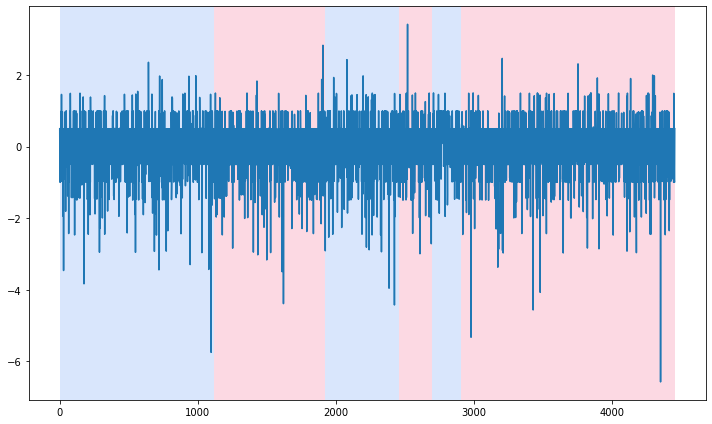

In [135]:
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt
# creation of data

model='rbf'
n_samples = polarity.shape[0]
algo = rpt.Window(width=200, model=model).fit(sentiments)
my_bkps= algo.predict(n_bkps=5)
rpt.show.display(sentiments, my_bkps, figsize=(10,6))

In [136]:
sentences[1000]

['great room for the money great hotel nice size rooms very convinient location']

In [137]:
sentences[1500]

['by the time four hours had gone by and i we were allowed to enter our room the food we had ordered was ice cold',
 'i managed hotels for several years and would have been there on site making sure every unruly individual was removed and would have had the best it support i could find onsite to fix the computer glitches that were causing the room keys not to work and the fire alarm to continually sound',
 'when they finally got to our floor to let us in our room i went inside and locked myself in the second room scared to death',
 'mind you it is new years eve and people are returning let us say feeling no pain but getting very angry at not being allowed to enter there rooms',
 'the room keys for each room would not work',
 'the manager did find a place for me to leave my car and told me once the non guest left my car would be moved to the parking garage',
 'i did not see them and i had a good view of the atrium floor from my room']

In [76]:
df_.iloc[17,:]

uid             b8b041e5-caff-4505-b499-01fc0b23fa98
lemma                            room use refreshing
sentence              room could use some refreshing
sentiment                                  -0.442706
date                             2015-05-24 00:00:00
score                                             80
t_room                                             1
t_meeting                                          0
t_lobby                                            0
t_view                                             0
t_pool                                             0
t_restaurant                                       0
t_renovation                                       1
polarity                                          -1
Name: 19928, dtype: object

# extra

In [48]:
from IPython.core.display import HTML, display
display(HTML("<style>.container {width:100% !important;} </style>"))

def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)


In [53]:
df_matches = df.copy()
for key, value in topic_words.items():
    word_list = "|".join(value)
    df_matches[key]= df_matches.lemma.str.contains(word_list).astype(int)
    
df_matches[df_matches.columns[-len(topic_words.keys()):]].sum(axis = 0).apply(lambda x: round(x/len(df_matches)*100,2))

t_room          22.13
t_meeting        3.30
t_lobby         14.92
t_view           3.48
t_pool           6.60
t_restaurant     5.05
t_renovation     0.93
dtype: float64

In [58]:
display_all(df_matches[:2])

,uid,lemma,sentence,sentiment,date,score,t_room,t_meeting,t_lobby,t_view,t_pool,t_restaurant,t_renovation,polarity
0,fcd73d28-e81c-4486-81b5-5ebee63a2946,attend hotel convention center mainstay,i attended metrocon and they used this hotel a...,0.489639,2008-05-01 00:00:00,100.0,0,0,1,0,1,0,0,1
1,fcd73d28-e81c-4486-81b5-5ebee63a2946,effortless room homey bed amazing,checkin was effortless the rooms were homey an...,0.499968,2008-05-01 00:00:00,100.0,1,0,0,0,0,0,0,1


In [56]:
polarities =[]
for sent in df_matches['sentiment']:
    if -0.35<sent<0.35:
        polarities.append(0)
    if sent>0.35:
        polarities.append(1)
    if sent < -0.35:
        polarities.append(-1)

In [57]:
df_matches['polarity']= polarities

In [43]:
for word in topic_words['t_room']:
    if word in model.wv.vocab:
        print(word, model.similarity('room', word))

room 1.0
bathroom 0.3098852
furniture 0.13873391
suites -0.049939875
suite 0.26112708
guest 0.12607759
shower 0.16085488
feature 0.018959247


/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
df_room_reno = df_matches[df_matches['t_room']==1]

In [82]:
df_room_reno = df_room_reno[df_room_reno['polarity']!=0]

In [83]:
df_ = df_room_reno.sort_values('date')

In [84]:
import numpy as np
polarity = np.array(df_.polarity)

In [87]:
len(polarity)

7907

In [80]:
df_.iloc[60,:].sentence

'we understand renovations have to happen but to check us into a room directly below is ridiculous'